# Example for execution of multiple circuits in QPUs

Before executing, you must set up and `qraise` the QPUs, check the `README.md` for instructions. For this examples it will be optimal to have more than one QPU and at least one of them with ideal AerSimulator.

### Importing and adding paths to `sys.path`

In [1]:
import os, sys

# path to access c++ files
installation_path = os.getenv("INSTALL_PATH")
sys.path.append(installation_path)

print(installation_path)
print(os.getenv("INFO_PATH"))

print(os.environ.get('LD_LIBRARY_PATH'))


/mnt/netapp1/Store_CESGA/home/cesga/jvazquez/works/cunqa/installation
/mnt/netapp1/Store_CESGA//home/cesga/jvazquez/.api_simulator/qpus.json
/opt/cesga/qmio/hpc/software/Compiler/gcc/12.3.0/boost/1.85.0/lib:/opt/cesga/qmio/hpc/software/Compiler/gcc/12.3.0/flexiblas/3.3.0/lib:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/ompi/lib:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/nccl_rdma_sharp_plugin/lib:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/sharp/lib:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/hcoll/lib:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/ucc/lib/ucc:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/ucc/lib:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/ucx/lib/ucx:/mnt/netapp1/Optcesga_FT2_RHEL7/qmio/hpc/software/Core/hpcx/2.17.1/ucx/lib:/opt/cesga/qmio/hpc/software/Compiler/gcc/12.3.0/openblas/0.3.24/lib:/opt/cesga/qmio/hpc/sof

### Let's get the QPUs that we q-raised!

In [2]:
from cunqa import getQPUs

qpus  = getQPUs()

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")


QPU 0, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 1, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.


The method `getQPUs()` accesses the information of the raised QPus and instanciates one `qpu.QPU` object for each, returning a list. If you are working with `jupyter notebook` we recomend to instanciate this method just once.

About the `qpu.QPU` objects:

- `QPU.id`: identificator of the virtual QPU, they will be asigned from 0 to n-1.


- `QPU.backend`: object `backend.Backend` that has information about the simulator and backend for the given QPU.


### Let's create a circuit to run in our QPUs!

We can create the circuit using `qiskit` or writting the instructions in the `json` format specific for `cunqa` (check the `README.md`), `OpenQASM2` is also supported. Here we choose not to complicate things and we create a `qiskit.QuantumCircuit`:

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

n = 5 # number of qubits

qc = QuantumCircuit(n)

qc.x(0); qc.x(n-1); qc.x(n-2)

qc.append(QFT(n), range(n))

qc.append(QFT(n).inverse(), range(n))

qc.measure_all()

display(qc.draw())

┌───┐┌──────┐┌───────┐ ░ ┌─┐            
   q_0: ┤ X ├┤0     ├┤0      ├─░─┤M├────────────
        └───┘│      ││       │ ░ └╥┘┌─┐         
   q_1: ─────┤1     ├┤1      ├─░──╫─┤M├─────────
             │      ││       │ ░  ║ └╥┘┌─┐      
   q_2: ─────┤2 QFT ├┤2 IQFT ├─░──╫──╫─┤M├──────
        ┌───┐│      ││       │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ X ├┤3     ├┤3      ├─░──╫──╫──╫─┤M├───
        ├───┤│      ││       │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤ X ├┤4     ├┤4      ├─░──╫──╫──╫──╫─┤M├
        └───┘└──────┘└───────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════╩══╩══╩══╩══╩═
                                  0  1  2  3  4

### Execution time! Let's do it sequentially

In [4]:
counts = []

for i, qpu in enumerate(qpus):

    print(f"For QPU {qpu.id}, with backend {qpu.backend.name}:")
    
    # 1)
    qjob = qpu.run(qc, transpile = True, shots = 1000)# non-blocking call

    # 2)
    result = qjob.result() # bloking call

    # 3)
    time = qjob.time_taken()
    counts.append(result.get_counts())

    print(f"Result: \n{result.get_counts()}\n Time taken: {time} s.")

For QPU 0, with backend BasicAer:
Result: 
{'11001': 1000}
 Time taken: 0.019545911 s.
For QPU 1, with backend BasicAer:
Result: 
{'11001': 1000}
 Time taken: 0.000873561 s.


1. First we run the circuit with the method `QPU.run()`, passing the circuit, transpilation options and other run parameters. It is important to note that if we don´t specify `transpilation=True`, default is `False`, therefore the user will be responsible for the tranpilation of the circuit accordingly to the native gates and topology of the backend. This method will return a `qjob.QJob` object. Be aware that the key point is that the `QPU.run()`  method is **asynchronous**.


2. To get the results of the simulation, we apply the method `QJob.result()`, which will return a `qjob.Result` object that stores the information in its class atributes. Depending on the simulator, we will have more or less information. Note that this is a **synchronous** method.


3. Once we have the `qjob.Result` object, we can obtain the counts dictionary by `Result.get_counts()`. Another method independent from the simulator is `Result.time_taken()`, that gives us the time of the simulation in seconds.

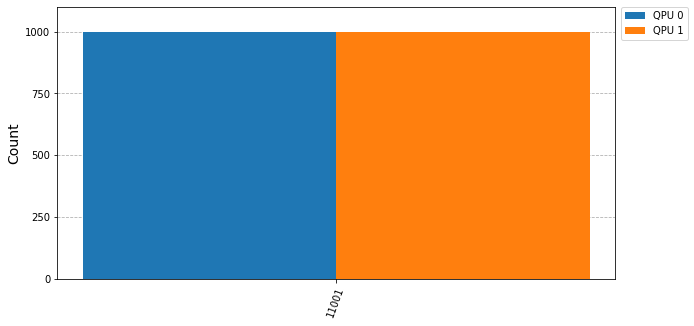

In [5]:
%matplotlib inline

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
plot_histogram(counts, figsize = (10, 5), bar_labels=False, legend = [f"QPU {i}" for i in range(len(qpus))])
# plt.savefig(f"counts_{len(qpus)}_qpus.png", dpi=200)

### Cool isn't it? But this circuit is too simple, let's try with a more complex one!

In [6]:
import json

# impoting from examples/circuits/
with open("circuits/circuit_15qubits_10layers.json", "r") as file:
    circuit = json.load(file)

We have examples of circuit in `json` format so you can create your own, but as we said, it is not necessary since `qiskit.QuantumCircuit` and `OpenQASM2` are supported.

### This circuit has 15 qubits and 10 intermidiate measurements, let's run it in AerSimulator

In [7]:
for qpu in qpus:
    if qpu.backend.name == "BasicAer":
        qpu0 = qpu
        break

qjob = qpu0.run(circuit, transpile = True, shots = 1000)

result = qjob.result() # bloking call

time = qjob.time_taken()

counts.append(result.get_counts())

print(f"Result: Time taken: {time} s.")

Result: Time taken: 9.131714186 s.


### Takes much longer ... let's parallelize n executions in n different QPUs

Remenber that sending circuits to a given QPU is a **non-blocking call**, so we can use a loop, keeping the `qjob.QJob` objects in a list.

Then, we can wait for all the jobs to finish with the `qjob.gather()` function. Let's measure time to check that we are parallelizing:

In [8]:
import time
from cunqa import gather

qjobs = []
n = len(qpus)

tick = time.time()

for qpu in qpus:
    qjobs.append(qpu.run(circuit, transpile = True, shots = 1000))
    
results = gather(qjobs) # this is a bloking call
tack = time.time()

In [9]:
print(f"Time taken to run {n} circuits in parallel: {tack - tick} s.")
print("Time for each execution:")
for i, result in enumerate(results):
    print(f"For QJob {i}, time taken: {result.time_taken} s.")

Time taken to run 2 circuits in parallel: 9.211505889892578 s.
Time for each execution:
For QJob 0, time taken: 9.059122133 s.
For QJob 1, time taken: 9.05945947 s.


Looking at the times we confirm that the circuits were run in parallel.